# Why is this tiny house so expensive ???

This notebook is similar to [this other house pricing model explanation](houses.ipynb), but we'll be using [TreeInterpretor](https://github.com/andosa/treeinterpreter), and not Lime here.

### Interpreting tree methods, on a house prices dataset

On this dataset we are going to build a model that predicts the price of houses in the city of Ames, IA. A [kaggle friendly competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/) features an interesting dataset of house prices with many cool features, from the surface of the 1st floor to the quality of the fence and the number of bathrooms in the basement.

We will build a Random Forest on this set (without going into feature engineering) and then try to see if we can extract explanations on these predictions 

#### Imports & data retrieval

Let's import some packages & the data

In [30]:
import warnings
warnings.filterwarnings('ignore')

import dataiku
from dataiku import pandasutils as pdu
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_ds = dataiku.Dataset("train")
train = train_ds.get_dataframe()

train_x = train.drop('SalePrice', axis=1)
train_y = train['SalePrice']

First thing: let's drop some not-so-useful features. 

We could go deep into feature engineering but this would need another entire notebook!

In [4]:
to_drop = ['Id', 'Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',
           'HouseStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
           'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'PoolArea', 'SaleCondition']
train_x = train_x.drop(to_drop, axis=1)
train_x.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType
0,60,RL,65,8450,Lvl,Inside,CollgCr,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196,PConc,706,0,150,856,GasA,SBrkr,856,854,0,1710,1,0,2,1,3,1,8,0,Attchd,2003,RFn,2,548,Y,0,61,0,0,0,2,2008,WD
1,20,RL,80,9600,Lvl,FR2,Veenker,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0,CBlock,978,0,284,1262,GasA,SBrkr,1262,0,0,1262,0,1,2,0,3,1,6,1,Attchd,1976,RFn,2,460,Y,298,0,0,0,0,5,2007,WD
2,60,RL,68,11250,Lvl,Inside,CollgCr,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162,PConc,486,0,434,920,GasA,SBrkr,920,866,0,1786,1,0,2,1,3,1,6,1,Attchd,2001,RFn,2,608,Y,0,42,0,0,0,9,2008,WD
3,70,RL,60,9550,Lvl,Corner,Crawfor,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0,BrkTil,216,0,540,756,GasA,SBrkr,961,756,0,1717,1,0,1,0,3,1,7,1,Detchd,1998,Unf,3,642,Y,0,35,272,0,0,2,2006,WD
4,60,RL,84,14260,Lvl,FR2,NoRidge,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350,PConc,655,0,490,1145,GasA,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,9,1,Attchd,2000,RFn,3,836,Y,192,84,0,0,0,12,2008,WD


We need to deal with categorical features now. Let's detect categorical features as all "string" features and add *MSSubClass* as well.

As we are using a random forest, a Label Encoding can be enough. With a linear model, OneHot Encoding would probably be better though.

In [10]:
features = train_x.columns.tolist()

# Categorical features: the non numerical features + 'MSSubClass'
categorical = list(train_x.select_dtypes(include=[object]).columns)
categorical.append('MSSubClass')

print 'Categorical features:', categorical

# Lime needs the indices of the categorical features
categorical_idx = [features.index(c) for c in categorical]

Categorical features: ['MSSubClass']


In [11]:
from sklearn.preprocessing import LabelEncoder

categorical_names = {}
for f in categorical_idx:
    feature = features[f]
    le = LabelEncoder()
    train_x.loc[:,feature] = le.fit_transform(train_x[feature])
    categorical_names[f] = le.classes_

train_x = train_x.astype(float)
train_x = train_x.fillna(0.0)

Let's now split the data into training and testing sets:

In [8]:
# Split the data into train-test: 80% in train, 20% in test
split = train_x.shape[0] * 0.8

test_x  = train_x.loc[split:]
train_x = train_x.loc[:split]

test_y  = train_y.loc[split:]
train_y = train_y.loc[:split]

print 'Train set has', train_x.shape[0], 'lines. Test set has', test_x.shape[0], 'lines.'

Train set has 1169 lines. Test set has 292 lines.


### Modeling

This is the part where we build our Random Forest model. The evaluation metric on Kaggle is the Root Mean Squared Logarithmic error, so let's score our test dataset and see if this model performs well.

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, n_jobs=12)
rf.fit(train_x, train_y)

from sklearn.metrics import mean_squared_error

y_pred = rf.predict(test_x)
score = np.sqrt(mean_squared_error(np.log(test_y), np.log(y_pred)))
print 'The RMSLE (root mean squared log error) is:', score

The RMSLE (root mean squared log error) is: 0.1538496261


Okay, I admit this is pretty lame compared to the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard), but this notebook is not about building the perfect model. Let's do some explanation instead.

### Explaining the predictions using TreeInterpreter

Let's compute the explanation from TreeInterpreter for a given house.

In [59]:
from treeinterpreter import treeinterpreter as ti

idx = 100

predictions, biases, contributions = ti.predict(rf, test_x.iloc[idx].reshape(1, -1))
contributions = pd.DataFrame(contributions, columns=test_x.columns)

We then sort these contributions according to their absolute value, and display the 10 most important ones:

Predicted proba is: 372455.07
True class is: 381000

Bias: 180711.949358


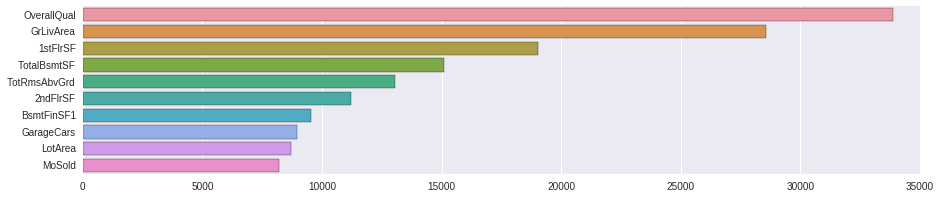

In [60]:
cntrb = contributions.iloc[0]
cntrb_abs = cntrb.abs()
argsrt = cntrb_abs.argsort()

cntrb = cntrb.iloc[argsrt.values[::-1]]

print 'Predicted price is: %.2f' % predictions[0]
print 'True price is:      %d' % test_y.iloc[idx]
print 
print 'Bias:', biases[0]

plt.figure(figsize=(15,3))
sns.barplot(y=cntrb.index[:10], x=cntrb.values[:10])
plt.show()

This house is quite expensive. Actually the overall bias is around 180,000$, and the price here is way higher: 381,000$.

This is why TreeInterpreter outputs only **positive features contributions**, ie: features that makes the price higher on this house. It seems like the overall quality and the house surface are the two main reasons for the house price, but also the number of rooms, the lot area, etc...

#### On a wrong prediction

Let's take a look at another one. On this house, the model prediction is not very accurate: the error represents 40% of the true price. 

Predicted price is: 174496.34
True price is:      122000


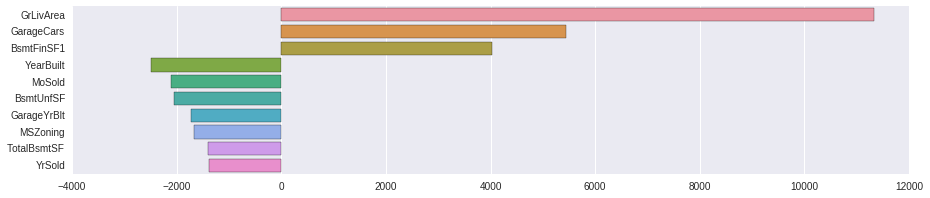

In [62]:
idx = 98

predictions, biases, contributions = ti.predict(rf, test_x.iloc[idx].reshape(1, -1))
contributions = pd.DataFrame(contributions, columns=test_x.columns)

cntrb = contributions.iloc[0]
cntrb_abs = cntrb.abs()
argsrt = cntrb_abs.argsort()

cntrb = cntrb.iloc[argsrt.values[::-1]]

print 'Predicted price is: %.2f' % predictions[0]
print 'True price is:      %d' % test_y.iloc[idx]

plt.figure(figsize=(15,3))
sns.barplot(y=cntrb.index[:10], x=cntrb.values[:10])
plt.show()

Here the model overprices the house by 50,000$. TreeInterpretor tells us that this because the feature `GrLivArea` has a very strong importance along with `GarageCars`. This house is probably quite big.

Yet we can see that many quality features tend to reduce the price: the year it's been build, the zoning, the year the garage has built, the surface of the basement, ...

This tell us that the Ground Living Area is maybe not that useful in itself, and maybe combining it to other features would make the predicted price closer to reality.

### One main issue with Tree Interpretor

Tree Interpretor is great as it allows us to see which features contribute the most to a given prediction. But it cannot tell us how features should be modified in order to change the prediction.

On this house pricing case for instance, it can't answer the question: *how can one make a price higher ?*. When a feature has a complex dependency with the target, and that several cuts are involved on the same feature in a decision trees, TreeInterpretor cannot know which way to go to make the price higher or lower.